In [5]:
import os
import gc
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from timeit import default_timer
start = default_timer()

def start_timer():
    st = default_timer()
    return st
def stop_timer(st):
    runtime = default_timer() - st
    print ("Elapsed time(sec): ", round(runtime,2))
# st = start_timer()
# stop_timer(st)

## 1. Load and process data 

In [4]:
st = start_timer()
input_dir = os.path.join(os.pardir, 'D:\Git Workspace\CreditRiskProject\data')
print('Input files:\n{}'.format(os.listdir(input_dir)))
print('Loading data sets...')

sample_size = None
app_train_df = pd.read_csv(os.path.join(input_dir, 'application_train.csv'), nrows=sample_size)
app_test_df = pd.read_csv(os.path.join(input_dir, 'application_test.csv'), nrows=sample_size)
bureau_df = pd.read_csv(os.path.join(input_dir, 'bureau.csv'), nrows=sample_size)
bureau_balance_df = pd.read_csv(os.path.join(input_dir, 'bureau_balance.csv'), nrows=sample_size)
credit_card_df = pd.read_csv(os.path.join(input_dir, 'credit_card_balance.csv'), nrows=sample_size)
pos_cash_df = pd.read_csv(os.path.join(input_dir, 'POS_CASH_balance.csv'), nrows=sample_size)
prev_app_df = pd.read_csv(os.path.join(input_dir, 'previous_application.csv'), nrows=sample_size)
install_df = pd.read_csv(os.path.join(input_dir, 'installments_payments.csv'), nrows=sample_size)
print('Data loaded.\nMain application training data set shape = {}'.format(app_train_df.shape))
print('Main application test data set shape = {}'.format(app_test_df.shape))
print('Positive target proportion = {:.2f}'.format(app_train_df['TARGET'].mean()))
stop_timer(st)

Input files:
['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
Loading data sets...
Data loaded.
Main application training data set shape = (307511, 122)
Main application test data set shape = (48744, 121)
Positive target proportion = 0.08


In [8]:
app_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def feature_engineering(app_data, bureau_df, bureau_balance_df, credit_card_df,
                        pos_cash_df, prev_app_df, install_df):
    """ 
    Process the input dataframes into a single one containing all the features. Requires
    a lot of aggregating of the supplementary datasets such that they have an entry per
    customer.
    
    Also, add any new features created from the existing ones
    """
    
    # # Add new features
    
    # Amount loaned relative to salary
    app_data['LOAN_INCOME_RATIO'] = app_data['AMT_CREDIT'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY_INCOME_RATIO'] = app_data['AMT_ANNUITY'] / app_data['AMT_INCOME_TOTAL']
    app_data['ANNUITY LENGTH'] = app_data['AMT_CREDIT'] / app_data['AMT_ANNUITY']
    
    # # Aggregate and merge supplementary datasets
    print('Combined train & test input shape before any merging  = {}'.format(app_data.shape))

    # Previous applications
    agg_funs = {'SK_ID_CURR': 'count', 'AMT_CREDIT': 'sum'}
    prev_apps = prev_app_df.groupby('SK_ID_CURR').agg(agg_funs)
    prev_apps.columns = ['PREV APP COUNT', 'TOTAL PREV LOAN AMT']
    merged_df = app_data.merge(prev_apps, left_on='SK_ID_CURR', right_index=True, how='left')

    # Average the rest of the previous app data
    prev_apps_avg = prev_app_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(prev_apps_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_PAVG'])
    print('Shape after merging with previous apps num data = {}'.format(merged_df.shape))
    
    # Previous app categorical features
    prev_app_df, cat_feats, _ = process_dataframe(prev_app_df)
    prev_apps_cat_avg = prev_app_df[cat_feats + ['SK_ID_CURR']].groupby('SK_ID_CURR')\
                             .agg({k: lambda x: str(x.mode().iloc[0]) for k in cat_feats})
    merged_df = merged_df.merge(prev_apps_cat_avg, left_on='SK_ID_CURR', right_index=True,
                            how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with previous apps cat data = {}'.format(merged_df.shape))

    # Credit card data - numerical features
    wm = lambda x: np.average(x, weights=-1/credit_card_df.loc[x.index, 'MONTHS_BALANCE'])
    credit_card_avgs = credit_card_df.groupby('SK_ID_CURR').agg(wm)   
    merged_df = merged_df.merge(credit_card_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CCAVG'])
    
    # Credit card data - categorical features
    most_recent_index = credit_card_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = credit_card_df.columns[credit_card_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(credit_card_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CCAVG'])
    print('Shape after merging with credit card data = {}'.format(merged_df.shape))

    # Credit bureau data - numerical features
    credit_bureau_avgs = bureau_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(credit_bureau_avgs, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_BAVG'])
    print('Shape after merging with credit bureau data = {}'.format(merged_df.shape))
    
    # Bureau balance data
    most_recent_index = bureau_balance_df.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
    bureau_balance_df = bureau_balance_df.loc[most_recent_index, :]
    merged_df = merged_df.merge(bureau_balance_df, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU',
                            how='left', suffixes=['', '_B_B'])
    print('Shape after merging with bureau balance data = {}'.format(merged_df.shape))

    # Pos cash data - weight values by recency when averaging
    wm = lambda x: np.average(x, weights=-1/pos_cash_df.loc[x.index, 'MONTHS_BALANCE'])
    f = {'CNT_INSTALMENT': wm, 'CNT_INSTALMENT_FUTURE': wm, 'SK_DPD': wm, 'SK_DPD_DEF':wm}
    cash_avg = pos_cash_df.groupby('SK_ID_CURR')['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                                                 'SK_DPD', 'SK_DPD_DEF'].agg(f)
    merged_df = merged_df.merge(cash_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_CAVG'])
    
    # Pos cash data data - categorical features
    most_recent_index = pos_cash_df.groupby('SK_ID_CURR')['MONTHS_BALANCE'].idxmax()
    cat_feats = pos_cash_df.columns[pos_cash_df.dtypes == 'object'].tolist()  + ['SK_ID_CURR']
    merged_df = merged_df.merge(pos_cash_df.loc[most_recent_index, cat_feats], left_on='SK_ID_CURR', right_on='SK_ID_CURR',
                       how='left', suffixes=['', '_CAVG'])
    print('Shape after merging with pos cash data = {}'.format(merged_df.shape))

    # Installments data
    ins_avg = install_df.groupby('SK_ID_CURR').mean()
    merged_df = merged_df.merge(ins_avg, left_on='SK_ID_CURR', right_index=True,
                                how='left', suffixes=['', '_IAVG'])
    print('Shape after merging with installments data = {}'.format(merged_df.shape))
    
    # Add more value counts
    merged_df = merged_df.merge(pd.DataFrame(bureau_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_BUREAU'])
    merged_df = merged_df.merge(pd.DataFrame(credit_card_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_CRED_CARD'])
    merged_df = merged_df.merge(pd.DataFrame(pos_cash_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_POS_CASH'])
    merged_df = merged_df.merge(pd.DataFrame(install_df['SK_ID_CURR'].value_counts()), left_on='SK_ID_CURR', 
                                right_index=True, how='left', suffixes=['', '_CNT_INSTALL'])
    print('Shape after merging with counts data = {}'.format(merged_df.shape))

    return merged_df

In [10]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """

    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    categorical_feats = categorical_feats
    encoder_dict = {}
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
        encoder_dict[feat] = encoder

    return input_df, categorical_feats.tolist(), encoder_dict

In [11]:
st = start_timer()
# Merge the datasets into a single one for training
len_train = len(app_train_df)
app_both = pd.concat([app_train_df, app_test_df])
merged_df = feature_engineering(app_both, bureau_df, bureau_balance_df, credit_card_df,
                                pos_cash_df, prev_app_df, install_df)

# Separate metadata
meta_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
meta_df = merged_df[meta_cols]
merged_df.drop(meta_cols, axis=1, inplace=True)

# Process the data set.
merged_df, categorical_feats, encoder_dict = process_dataframe(input_df=merged_df)
stop_timer(st)

Combined train & test input shape before any merging  = (356255, 125)
Shape after merging with previous apps num data = (356255, 147)
Shape after merging with previous apps cat data = (356255, 163)
Shape after merging with credit card data = (356255, 185)
Shape after merging with credit bureau data = (356255, 198)
Shape after merging with bureau balance data = (356255, 200)
Shape after merging with pos cash data = (356255, 205)
Shape after merging with installments data = (356255, 212)
Shape after merging with counts data = (356255, 216)
Elapsed time(sec):  3953.22


In [12]:
st = start_timer()
# Capture other categorical features not as object data types:
non_obj_categoricals = [
    'FONDKAPREMONT_MODE',
    'HOUR_APPR_PROCESS_START',
    'HOUSETYPE_MODE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 
    'NAME_TYPE_SUITE', 
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 
    'WALLSMATERIAL_MODE',
    'WEEKDAY_APPR_PROCESS_START', 
    'NAME_CONTRACT_TYPE_BAVG',
    'WEEKDAY_APPR_PROCESS_START_BAVG',
    'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 
    'NAME_PAYMENT_TYPE',
    'CODE_REJECT_REASON', 
    'NAME_TYPE_SUITE_BAVG', 
    'NAME_CLIENT_TYPE',
    'NAME_GOODS_CATEGORY', 
    'NAME_PORTFOLIO', 
    'NAME_PRODUCT_TYPE',
    'CHANNEL_TYPE', 
    'NAME_SELLER_INDUSTRY', 
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION', 
    'NAME_CONTRACT_STATUS_CCAVG', 
    'STATUS',
    'NAME_CONTRACT_STATUS_CAVG'
]
categorical_feats = categorical_feats + non_obj_categoricals
stop_timer(st)

Elapsed time(sec):  0.0


In [13]:
st = start_timer()
# Extract target before scaling
labels = merged_df.pop('TARGET')
labels = labels[:len_train]

# Reshape (one-hot)
target = np.zeros([len(labels), len(np.unique(labels))])
target[:, 0] = labels == 0
target[:, 1] = labels == 1
stop_timer(st)

Elapsed time(sec):  0.28


#### 1.1 Check nulls

In [14]:
st = start_timer()
null_counts = merged_df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_ratios = null_counts / len(merged_df)

# Drop columns over x% null
null_thresh = .8
null_cols = null_ratios[null_ratios > null_thresh].index
merged_df.drop(null_cols, axis=1, inplace=True)
print('Columns dropped for being over {}% null:'.format(100*null_thresh))
for col in null_cols:
    print(col)
    if col in categorical_feats:
        categorical_feats.pop(col)
    
# Fill the rest with the mean (TODO: do something better!)
# merged_df.fillna(merged_df.median(), inplace=True)
merged_df.fillna(0, inplace=True)
stop_timer(st)

Columns dropped for being over 80.0% null:
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_DRAWINGS_POS_CURRENT
CNT_INSTALMENT_MATURE_CUM
MONTHS_BALANCE_B_B
Elapsed time(sec):  3.33


#### 1.2 Identify categorical variables

In [15]:
cat_feats_idx = np.array([merged_df.columns.get_loc(x) for x in categorical_feats])
int_feats_idx = [merged_df.columns.get_loc(x) for x in non_obj_categoricals]
cat_feat_lookup = pd.DataFrame({'feature': categorical_feats, 'column_index': cat_feats_idx})
cat_feat_lookup.head()

,column_index,feature
0,18,CODE_GENDER
1,32,EMERGENCYSTATE_MODE
2,63,FLAG_OWN_CAR
3,64,FLAG_OWN_REALTY
4,73,FONDKAPREMONT_MODE


In [16]:
cont_feats_idx = np.array(
    [merged_df.columns.get_loc(x) 
     for x in merged_df.columns[~merged_df.columns.isin(categorical_feats)]]
)
cont_feat_lookup = pd.DataFrame(
    {'feature': merged_df.columns[~merged_df.columns.isin(categorical_feats)], 
     'column_index': cont_feats_idx}
)
cont_feat_lookup.head()

,column_index,feature
0,0,AMT_ANNUITY
1,1,AMT_CREDIT
2,2,AMT_GOODS_PRICE
3,3,AMT_INCOME_TOTAL
4,4,AMT_REQ_CREDIT_BUREAU_DAY


#### 1.3 Scaling

In [17]:
scaler = StandardScaler()
final_col_names = merged_df.columns
merged_df = merged_df.values
merged_df[:, cont_feats_idx] = scaler.fit_transform(merged_df[:, cont_feats_idx])

scaler_2 = MinMaxScaler(feature_range=(0, 1))
merged_df[:, int_feats_idx] = scaler_2.fit_transform(merged_df[:, int_feats_idx])

## 2. Building the graph

In [18]:
# Re-separate into labelled and unlabelled
train_df = merged_df[:len_train]
predict_df = merged_df[len_train:]
del merged_df, app_train_df, app_test_df, bureau_df, bureau_balance_df, credit_card_df, pos_cash_df, prev_app_df
gc.collect()

# Create a validation set to check training performance
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, test_size=0.1, random_state=2, stratify=target[:, 0])

In [19]:
# Fixed graph parameters
# EMBEDDING_SIZE = 3  # Use cardinality / 2 instead
N_HIDDEN_1 = 80
N_HIDDEN_2 = 80
N_HIDDEN_3 = 40
n_cont_inputs = X_train[:, cont_feats_idx].shape[1]
n_classes = 2

# Learning parameters
LEARNING_RATE = 0.01
N_EPOCHS = 30
N_ITERATIONS = 400
BATCH_SIZE = 250

print('Number of continous features: ', n_cont_inputs)
print('Number of categoricals pre-embedding: ', X_train[:, cat_feats_idx].shape[1])

Number of continous features:  164
Number of categoricals pre-embedding:  65


In [20]:
def embed_and_attach(X, X_cat, cardinality):  
    embedding = tf.Variable(tf.random_uniform([cardinality, cardinality // 2], -1.0, 1.0))
    embedded_x = tf.nn.embedding_lookup(embedding, X_cat) 
    return tf.concat([embedded_x, X], axis=1)

In [21]:
# # Graph
tf.reset_default_graph()

# Define placeholders for the categorical varaibles
cat_placeholders, cat_cardinalities = [], []
for idx in cat_feats_idx:
    exec('X_cat_{} = tf.placeholder(tf.int32, shape=(None, ), name=\'X_cat_{}\')'.format(idx, idx))
    exec('cat_placeholders.append(X_cat_{})'.format(idx))
    cat_cardinalities.append(len(np.unique(np.concatenate([train_df[:, idx], 
                                                           predict_df[:, idx]], axis=0))))
    
# Other placeholders
X_cont = tf.placeholder(tf.float32, shape=(None, n_cont_inputs), name='X_cont')
y = tf.placeholder(tf.int32, shape=(None, n_classes), name='labels')
train_mode = tf.placeholder(tf.bool)

# Add embeddings to input
X = tf.identity(X_cont)
for feat, card in zip(cat_placeholders, cat_cardinalities):
    X = embed_and_attach(X, feat, card)

# Define the network layers. 
# Overfitting is a challenge so add L2 regularisation to weights in 1st layer & 
# a couple of dropout layers
with tf.name_scope('dnn'):
    hidden_layer_1 = tf.layers.dense(inputs=X,
                                     units=N_HIDDEN_1,
                                     name='first_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.3))
    hidden_layer_1 = tf.layers.batch_normalization(hidden_layer_1, training=train_mode)
    hidden_layer_1 = tf.nn.relu(hidden_layer_1)
    
    drop_layer_1 = tf.layers.dropout(inputs=hidden_layer_1, 
                                     rate=0.4, 
                                     name='first_dropout_layer',
                                     training=train_mode)

    hidden_layer_2 = tf.layers.dense(inputs=drop_layer_1,
                                     units=N_HIDDEN_2,
                                     name='second_hidden_layer',
                                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
    hidden_layer_2 = tf.layers.batch_normalization(hidden_layer_2, training=train_mode)
    hidden_layer_2 = tf.nn.relu(hidden_layer_2)
                                     
    drop_layer_2 = tf.layers.dropout(inputs=hidden_layer_2, 
                                     rate=0.2, 
                                     name='second_dropout_layer',
                                     training=train_mode)

    hidden_layer_3 = tf.layers.dense(inputs=drop_layer_2,
                                     units=N_HIDDEN_3,
                                     name='third_hidden_layer')
    hidden_layer_3 = tf.layers.batch_normalization(hidden_layer_3, training=train_mode)
    hidden_layer_3 = tf.nn.relu(hidden_layer_3)

    logits = tf.layers.dense(inputs=hidden_layer_3,
                             units=n_classes,
                             name='outputs')

# Define the loss function for training as cross entropy
with tf.name_scope('loss'):
    xent = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
    loss = tf.reduce_mean(xent, name='loss')

# Define the optimiser
with tf.name_scope('train'):
    optimiser = tf.train.AdamOptimizer()  # AdagradOptimizer(learning_rate=LEARNING_RATE)
    train_step = optimiser.minimize(loss)

# Output the class probabilities to I can get the AUC
with tf.name_scope('eval'):
    predict = tf.argmax(logits, axis=1, name='class_predictions')
    predict_proba = tf.nn.softmax(logits, name='probability_predictions')

# Initialisation node and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 3. Training the NN

In [22]:
def get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, batch_X, batch_y=None,
                 training=False):
    """ Return a feed dict for the graph including all the categorical features
    to embed """
    
    # Continuous X features and the labels if training run
    feed_dict = {X_cont: batch_X[:, cont_feats_idx]}
    if batch_y is not None:
        feed_dict[y] = batch_y
        
    # Loop through the categorical features to provide values for the placeholders
    for idx, tensor in zip(cat_feats_idx, cat_placeholders):
        feed_dict[tensor] = batch_X[:, idx].reshape(-1, ).astype(int)
        
    # Training mode or not
    feed_dict[train_mode] = training
        
    return feed_dict

In [23]:
st = start_timer()
train_auc, valid_auc = [], []
n_rounds_not_improved = 0
early_stopping_epochs = 2
with tf.Session() as sess:

    init.run()

    # Begin epoch loop
    print('Training for {} iterations over {} epochs with batchsize {} ...'
          .format(N_ITERATIONS, N_EPOCHS, BATCH_SIZE))
    for epoch in range(N_EPOCHS):
        
        # Iteration loop
        for iteration in range(N_ITERATIONS):

            # Get random selection of data for batch GD. Upsample positive classes to make it
            # balanced in the training batch
            pos_ratio = 0.5
            pos_idx = np.random.choice(np.where(y_train[:, 1] == 1)[0], 
                                       size=int(np.round(BATCH_SIZE*pos_ratio)))
            neg_idx = np.random.choice(np.where(y_train[:, 1] == 0)[0], 
                                       size=int(np.round(BATCH_SIZE*(1-pos_ratio))))
            idx = np.concatenate([pos_idx, neg_idx])
            
            # Run training
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            sess.run([train_step, extra_update_ops], 
                     feed_dict=get_feed_dict(cat_feats_idx, cat_placeholders, cont_feats_idx, 
                                             X_train[idx, :], y_train[idx, :], 1))

        # Check on the AUC
        y_pred_train, y_prob_train = sess.run(
            [predict, predict_proba], feed_dict=get_feed_dict(
                cat_feats_idx, cat_placeholders, cont_feats_idx, X_train, y_train, False))
        train_auc.append(roc_auc_score(y_train[:, 1], y_prob_train[:, 1]))
        
        y_pred_val, y_prob_val = sess.run(
            [predict, predict_proba], feed_dict=get_feed_dict(
                cat_feats_idx, cat_placeholders, cont_feats_idx, X_valid, y_valid, False))
        valid_auc.append(roc_auc_score(y_valid[:, 1], y_prob_val[:, 1]))
        
        # Early stopping
        if epoch > 1:
            best_epoch_so_far = np.argmax(valid_auc[:-1])
            if valid_auc[epoch] <= valid_auc[best_epoch_so_far]:
                n_rounds_not_improved += 1
            else:
                n_rounds_not_improved = 0       
            if n_rounds_not_improved > early_stopping_epochs:
                print('Early stopping due to no improvement after {} epochs.'
                      .format(early_stopping_epochs))
                break
        print('Epoch = {}, Train AUC = {:.8f}, Valid AUC = {:.8f}'
              .format(epoch, train_auc[epoch], valid_auc[epoch]))

    # Once trained, make predictions
    print('Training complete.')
    y_prob = sess.run(predict_proba, feed_dict=get_feed_dict(
        cat_feats_idx, cat_placeholders, cont_feats_idx, predict_df, None, False))

stop_timer(st)

Training for 400 iterations over 30 epochs with batchsize 250 ...
Epoch = 0, Train AUC = 0.74414807, Valid AUC = 0.73021247
Epoch = 1, Train AUC = 0.74969237, Valid AUC = 0.73756863
Epoch = 2, Train AUC = 0.75592648, Valid AUC = 0.74044438
Epoch = 3, Train AUC = 0.75745168, Valid AUC = 0.74233362
Epoch = 4, Train AUC = 0.76175557, Valid AUC = 0.74466943
Epoch = 5, Train AUC = 0.76428523, Valid AUC = 0.74668103
Epoch = 6, Train AUC = 0.76785848, Valid AUC = 0.74869863
Epoch = 7, Train AUC = 0.76857705, Valid AUC = 0.74879948
Epoch = 8, Train AUC = 0.77075104, Valid AUC = 0.75145131
Epoch = 9, Train AUC = 0.77458465, Valid AUC = 0.75228569
Epoch = 10, Train AUC = 0.77720872, Valid AUC = 0.75486234
Epoch = 11, Train AUC = 0.77916478, Valid AUC = 0.75449950
Epoch = 12, Train AUC = 0.77950668, Valid AUC = 0.75480961
Epoch = 13, Train AUC = 0.78174084, Valid AUC = 0.75795595
Epoch = 14, Train AUC = 0.78218967, Valid AUC = 0.75530273
Epoch = 15, Train AUC = 0.78494238, Valid AUC = 0.75679378


## 4. Analysis and Submission 

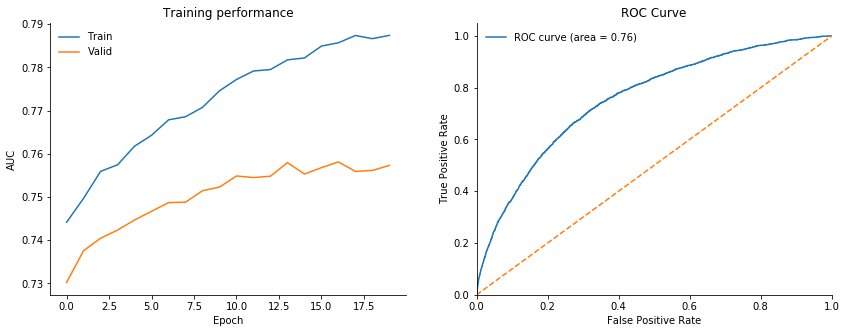

In [24]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])
ax.plot(np.arange(len(train_auc)), train_auc, label='Train')
ax.plot(np.arange(len(valid_auc)), valid_auc, label='Valid')
ax.set_xlabel('Epoch')
ax.set_ylabel('AUC')
ax.set_title('Training performance')

fpr, tpr, _ = roc_curve(y_valid[:, 1], y_prob_val[:, 1])
ax1.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(valid_auc[epoch]))
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

for a in [ax, ax1]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.legend(frameon=False)

plt.show()

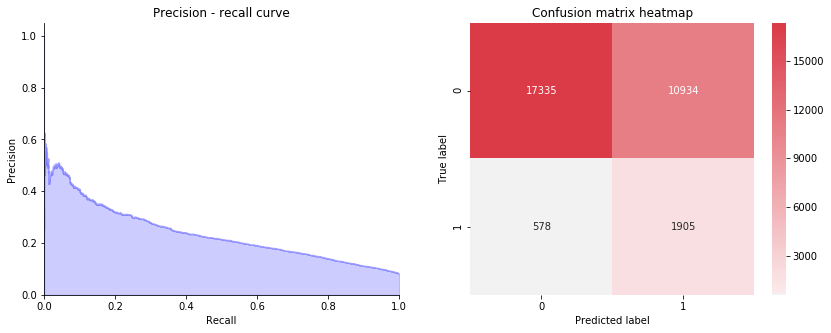

In [25]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])

# Precision recall curve
precision, recall, _ = precision_recall_curve(y_valid[:, 1], y_prob_val[:, 1])
ax.step(recall, precision, color='b', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Precision - recall curve')

# Confusion matrix
cnf_matrix = confusion_matrix(y_valid[:, 1], np.argmax(y_prob_val, axis=1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax1, cmap=cmap, center=0)
ax1.set_title('Confusion matrix heatmap')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

plt.show()

In [26]:
out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_prob[:, 1]})
out_df.to_csv('nn_submission.csv', index=False)